En primer lugar debemos instalar ROOT, ya que necesitamos la libreria root-numpy. Este paso sólo se hace una vez. Una vez hecho es recomendable comentar el contenido de la celda inferior.

In [ ]:
'''
!wget https://github.com/MohamedElashri/HEP-ML/releases/download/ROOT/ROOT.tar.zip
!unzip /content/ROOT.tar.zip
!tar -xf  ROOT.tar
!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion

import sys
sys.path.append("/content/root_build/")
sys.path.append("/content/root_build/bin/")
sys.path.append("/content/root_build/include/")
sys.path.append("/content/root_build/lib/")
import ctypes
ctypes.cdll.LoadLibrary('/content/root_build/lib//libCore.so')
ctypes.cdll.LoadLibrary('/content/root_build/lib//libThread.so')
ctypes.cdll.LoadLibrary('/content/root_build/lib//libTreePlayer.so')
'''

'\n!wget https://github.com/MohamedElashri/HEP-ML/releases/download/ROOT/ROOT.tar.zip\n!unzip /content/ROOT.tar.zip\n!tar -xf  ROOT.tar\n!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion\n\nimport sys\nsys.path.append("/content/root_build/")\nsys.path.append("/content/root_build/bin/")\nsys.path.append("/content/root_build/include/")\nsys.path.append("/content/root_build/lib/")\nimport ctypes\nctypes.cdll.LoadLibrary(\'/content/root_build/lib//libCore.so\')\nctypes.cdll.LoadLibrary(\'/content/root_build/lib//libThread.so\')\nctypes.cdll.LoadLibrary(\'/content/root_build/lib//libTreePlayer.so\')\n'

Instalando los paquetes necesarios

In [ ]:
%%capture
!pip install numpy
!pip install uproot
!pip install matplotlib
!pip install root-numpy
!pip install lmfit
!pip install awkward

Importando las librerias necesarias

In [ ]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
#import root_numpy
from lmfit.models import PolynomialModel, GaussianModel
from matplotlib.ticker import MaxNLocator, AutoMinorLocator

# Descubriendo el bosón de Higgs

En esta actividad vamos a reconstruir el bosón de Higgs a partir de los datos de libre acceso que se pueden encontrar en el link https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/. Como sabemos el bosón de Higgs es una partícula del modelo estandar con una masa de aproximada de  $125\ [GeV]$, la cual proviene de la cuantización del campo de Higgs. Este campo es responsable de darle masa a las demás particulas del modelo estandar por medio del Mecanismo de Higgs. Debido a la forma en que el boson de Higgs interactua con las demás partículas del modelo estandar, esta puede decaer por varios canales de decaimiento. Dentro de todos los modos de decamiento posibles (ver http://opendata.atlas.cern/release/2020/documentation/visualization/the-higgs-boson.html para más detalles), en esta actividad nos vamos a centrar el canal en donde el Higgs decae a dos fotones, es decir $H\rightarrow \gamma\gamma$ (ver el artículo https://arxiv.org/pdf/1207.7214.pdf para más detalles). Los diagramas de Feynman junto al histograma en donde se reporta la reconstrucción de la masa del Higgs en el mencionado canal se puede ver a continuación:

<CENTER><img src="https://www.researchgate.net/profile/Oliver-Passon/publication/342599946/figure/fig4/AS:908484686118913@1593611036533/Left-Leading-order-contributions-to-the-decay-of-the-Higgs-boson-into-two-photons.png" style="width:20%"></CENTER>

Por lo tanto, el objetivo principal de esta actividad es reproducir el histograma que acabamos de mostrar.

# Comienza el análisis

Primero definimos que fracción de los eventos queremos procesar. Si queremos procesar todos los datos, entonces fijamos este valor a 1. Por el contrario, si queremos menos datos, entonces diminuimos el valor.

In [ ]:
fraction = 0.1

Ahora creamos la variable $\textrm{url_data_repository}$ en donde vamos a almacenar el link del repositorio en cual encontraremos nuestros archivos $\textbf{.root}$ con los datos a procesar. El nombre de estos archivos se almacenan en la lista $\textrm{data_names}$. Como vemos primero almacenamos solo un archivo, pero podemos añadir más entradas a esta lista para obtener más datos y por lo tanto más estadistica. Sin embargo sólo vamos a considerar un sólo archivo, ya que el tiempo de ejecución del algoritmo crece significativamente al tomar más archivos de datos.

In [ ]:
url_data_repository = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/"
data_names = ["data_A.GamGam.root"]
#data_names = ["data_A.GamGam.root", "data_B.GamGam.root"]
#data_names = ["data_A.GamGam.root", "data_B.GamGam.root", "data_C.GamGam.root"]
#data_names = ["data_A.GamGam.root", "data_B.GamGam.root", "data_C.GamGam.root", "data_D.GamGam.root"]

Ahora vamos a definir una función que nos entrega como salida los $\textbf{Trees}$ y $\textbf{Branches}$ del archivo $\textbf{.root}$ que estamos considerando. Los archivos con extensión $\textbf{.root}$ son ampliamente usados en el contexto de análisis de datos en el LHC y entre otros contextos además. La estructura de estos archivos es muy similar a un directorio madre, el cual tiene varios subdirectorios, en los cuales podemos encontrar archivos de diferente tipo. En este tipo de archivos, el directorio madre sería el $\textbf{Tree}$, el cual lleva un nombre. Luego, este $\textbf{Tree}$ se subdivide en $\textbf{Branches}$, que en nuestra analogía vendrían a ser los subdirectorios, y finalmente es en estas branches en donde encontramos nuestros datos (los archivos de diferente tipo).

In [ ]:
def get_keys(data_path):
    uproot_path = uproot.open(data_path)
    key_names = uproot_path.keys()
    tree = uproot_path[key_names[0]]
    tree_keys = tree.keys()
    return tree, tree_keys

Veamos el nombre de las branches de los archivos $\textbf{.root}$ que estamos considerando en la lista $\textrm{data_names}$:

In [ ]:
for i in range(len(data_names)):
    print("Branches in file", data_names[i], ": ", get_keys(url_data_repository + data_names[i])[1])

Branches in file data_A.GamGam.root :  ['runNumber', 'eventNumber', 'channelNumber', 'mcWeight', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_PHOTON', 'scaleFactor_TAU', 'scaleFactor_BTAG', 'scaleFactor_LepTRIGGER', 'scaleFactor_PhotonTRIGGER', 'trigE', 'trigM', 'trigP', 'lep_n', 'lep_truthMatched', 'lep_trigMatched', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_z0', 'lep_charge', 'lep_type', 'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'lep_trackd0pvunbiased', 'lep_tracksigd0pvunbiased', 'met_et', 'met_phi', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_jvt', 'jet_trueflav', 'jet_truthMatched', 'jet_MV2c10', 'photon_n', 'photon_truthMatched', 'photon_trigMatched', 'photon_pt', 'photon_eta', 'photon_phi', 'photon_E', 'photon_isTightID', 'photon_ptcone30', 'photon_etcone20', 'photon_convType', 'tau_n', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_E', 'tau_isTightID', 'tau_truthMatched', 'tau_trigMatched', 'tau_nTracks', 'tau_BDTid', 'ditau_m', 'lep_pt_

El significado de algunas de estas branches se puede ver a continuación:

<CENTER><img src="http://opendata.atlas.cern/release/2020/documentation/datasets/pictures/tab_05.png" style="width:20%"></CENTER>

Para nuestro propósito sólo estamos interesados en las branches $\textbf{photon_pt}$, $\textbf{photon_eta}$, $\textbf{photon_phi}$, $\textbf{photon_E}$, $\textbf{photon_isTightID}$ y $\textbf{photon_ptcone30}$. Para extraer los datos de esas branches definamos una función que nos entrege como resultado arreglos con los datos de las branches anteriormente mencionadas:

In [ ]:
def get_some_branches(data_list, list_with_branches_keys):
    for i in data_list:
        keys = get_keys(url_data_repository + i)[0]
        for j in list_with_branches_keys:
            if j == "photon_pt":
                photon_pt_list = keys[j].array()
            elif j == "photon_eta":
                photon_eta_list = keys[j].array()
            elif j == "photon_phi":
                photon_phi_list = keys[j].array()
            elif j == "photon_E":
                photon_E_list = keys[j].array()
            elif j == "photon_isTightID":
                photon_isTightID_list = keys[j].array()
            elif j == "photon_etcone20":
                photon_etcone20_list = keys[j].array()

    return photon_pt_list, photon_eta_list, photon_phi_list, photon_E_list, photon_isTightID_list, photon_etcone20_list

El siguiente paso es crear arreglos vacios con nombres similares a los de las branches de interes. Estos arreglos serán llenados con la función que hemos construido por medio de un loop. De esta forma ya estamos preparados para manipular nuestros datos para la recontrucción del bosón de Higgs.  

In [ ]:
photon_pt_list = []
photon_eta_list = []
photon_phi_list = []
photon_E_list = []
photon_isTightID_list = []
photon_etcone20_list = []

some_branches = []

for i in data_names:
    some_branches.append(get_some_branches(data_names, get_keys(url_data_repository + i)[1]))

for this_branch in some_branches:
    photon_pt_list.extend(this_branch[0])
    photon_eta_list.extend(this_branch[1])
    photon_phi_list.extend(this_branch[2])
    photon_E_list.extend(this_branch[3])
    photon_isTightID_list.extend(this_branch[4])
    photon_etcone20_list.extend(this_branch[5])

Echemos un vistazo a los primeros datos alamacenados en estos arreglos:

In [ ]:
print("Elementos en el arreglo photon_pt_list: ")
for i in range(3):
    print(photon_pt_list[i])
print("Número de elementos en el arreglo photon_pt_list: " + str(len(photon_pt_list)) + "\n")

print("Elementos en el arreglo photon_eta_list: ")
for i in range(3):
    print(photon_eta_list[i])
print("Número de elementos en el arreglo photon_eta_list: " + str(len(photon_eta_list)) + "\n")

print("Elementos en el arreglo photon_phi_list: ")
for i in range(3):
    print(photon_phi_list[i])
print("Número de elementos en el arreglo photon_phi_list: " + str(len(photon_phi_list)) + "\n")

print("Elementos en el arreglo photon_E_list: ")
for i in range(3):
    print(photon_E_list[i])
print("Número de elementos en el arreglo photon_E_list: " + str(len(photon_E_list)) + "\n")

print("Elementos en el arreglo photon_isTightID_list: ")
for i in range(3):
    print(photon_isTightID_list[i])
print("Número de elementos en el arreglo photon_pt_list: " + str(len(photon_isTightID_list)) + "\n")

print("Elementos en el arreglo photon_etcone20_list: ")
for i in range(3):
    print(photon_etcone20_list[i])
print("Número de elementos en el arreglo photon_etcone20_list: " + str(len(photon_isTightID_list)) + "\n")

Elementos en el arreglo photon_pt_list: 
[4.67e+04, 2.94e+04]
[6.09e+04, 3.78e+04]
[3.92e+04, 2.53e+04]
Número de elementos en el arreglo photon_pt_list: 430344

Elementos en el arreglo photon_eta_list: 
[-1.78, 1.17]
[0.174, -0.969]
[0.139, -1.31]
Número de elementos en el arreglo photon_eta_list: 430344

Elementos en el arreglo photon_phi_list: 
[-2.19, 1.13]
[1.86, -0.888]
[1.02, -1.79]
Número de elementos en el arreglo photon_phi_list: 430344

Elementos en el arreglo photon_E_list: 
[1.42e+05, 5.19e+04]
[6.18e+04, 5.7e+04]
[3.96e+04, 5.03e+04]
Número de elementos en el arreglo photon_E_list: 430344

Elementos en el arreglo photon_isTightID_list: 
[False, False]
[False, False]
[False, False]
Número de elementos en el arreglo photon_pt_list: 430344

Elementos en el arreglo photon_etcone20_list: 
[1.21e+03, 575]
[5.4e+03, 2.01e+03]
[3.26e+03, 2.11e+04]
Número de elementos en el arreglo photon_etcone20_list: 430344



Como vemos todos los arreglos que hemos construido tienen la forma de una matriz con $430344$ filas y $2$ columnas, donde el número de filas va a crecer si consideramos más archivos en el arreglo $\textrm{data_names}$. Como podemos constatar acá estamos considerando sólo 6 branches, las cuales poseen $2x430344$ datos cada una. Si consideramos todas las branches de nuestro archivo, entonces vamos a tener que procesar un total de $2x430344x(\mathrm{Número\ de\ branches})$ datos, y este número sigue creciendo a medida que tomamos más archivos en el arreglo $\textrm{data_names}$. Esto nos lleva a pensar en la gran cantidad de datos que pueden tomar los experimentos del LHC, teniendo como consecuencia que estos archivos ocupen una gran cantidad de espacio de almacenamiento.

Volviendo a nuestro análisis, la primera columna de estos arreglos poseen la información del photon leading, y la segunda columna posee la información del fotón sub-leading. Sin embargo, por temas de simplicidad a la hora de recontruir la masa del Higgs, conviene transponer estos arreglos, obteniendo como resultado arreglos con $430344$ columnas y $2$ filas, en donde el arreglo de la fila $1$ va a contener la información del fotón leading y la segunda fila va a contener la información del fotón sub-leading. Para eso utilizamos el método $\textbf{np.transpose}$ de la libreria numpy:

In [ ]:
photon_pt_list_new = []
photon_eta_list_new = []
photon_phi_list_new = []
photon_E_list_new = []
photon_isTightID_list_new = []
photon_etcone20_list_new = []

In [ ]:
for i in range(int(len(photon_pt_list)*fraction)):
    if len(photon_pt_list[i]) != 2:
        continue
    photon_pt_list_new.append(photon_pt_list[i])

In [ ]:
for i in range(int(len(photon_pt_list)*fraction)):
    if len(photon_eta_list[i]) != 2:
        continue
    photon_eta_list_new.append(photon_eta_list[i])

In [ ]:
for i in range(int(len(photon_pt_list)*fraction)):
    if len(photon_phi_list[i]) != 2:
        continue
    photon_phi_list_new.append(photon_phi_list[i])

In [ ]:
for i in range(int(len(photon_pt_list)*fraction)):
    if len(photon_E_list[i]) != 2:
        continue
    photon_E_list_new.append(photon_E_list[i])

In [ ]:
for i in range(int(len(photon_pt_list)*fraction)):
    if len(photon_isTightID_list[i]) != 2:
        continue
    photon_isTightID_list_new.append(photon_isTightID_list[i])

In [ ]:
for i in range(int(len(photon_pt_list)*fraction)):
    if len(photon_etcone20_list[i]) != 2:
        continue
    photon_etcone20_list_new.append(photon_etcone20_list[i])

In [ ]:
photon_pt_to_calculate_mass = np.array(photon_pt_list_new).T

In [ ]:
photon_eta_to_calculate_mass = np.array(photon_eta_list_new).T

In [ ]:
photon_phi_to_calculate_mass = np.array(photon_phi_list_new).T

In [ ]:
photon_E_to_calculate_mass = np.array(photon_E_list_new).T

In [ ]:
photon_isTightID_to_calculate_mass = np.array(photon_isTightID_list_new).T

In [ ]:
photon_etcone20_to_calculate_mass = np.array(photon_etcone20_list_new).T

Echemos un vistazo a estos nuevos arreglos:

In [ ]:
print("Elementos en el arreglo photon_pt_list:" ,photon_pt_to_calculate_mass, "\n")
print("Elementos en el arreglo photon_eta_list:" ,photon_eta_to_calculate_mass, "\n")
print("Elementos en el arreglo photon_phi_list:" ,photon_phi_to_calculate_mass, "\n")
print("Elementos en el arreglo photon_E_list:" ,photon_E_to_calculate_mass, "\n")
print("Elementos en el arreglo photon_isTightID_list:" ,photon_isTightID_to_calculate_mass, "\n")
print("Elementos en el arreglo photon_etcone20_list:" ,photon_etcone20_to_calculate_mass, "\n")

Elementos en el arreglo photon_pt_list: [[ 46690.223  60888.74   39186.21  ...  95674.91  108786.25   87315.195]
 [ 29442.607  37795.01   25327.361 ...  30258.053  27494.418  70316.45 ]] 

Elementos en el arreglo photon_eta_list: [[-1.7790892   0.1741194   0.13933659 ... -0.73444015 -1.8164222
  -1.3540671 ]
 [ 1.1680628  -0.9689641  -1.309055   ... -0.6575072   0.7362977
   0.91921216]] 

Elementos en el arreglo photon_phi_list: [[-2.1864736   1.8595004   1.0165337  ... -0.99144626  0.8353023
  -1.6357179 ]
 [ 1.1273633  -0.88825077 -1.787857   ...  1.7098373  -2.6559947
   1.1161007 ]] 

Elementos en el arreglo photon_E_list: [[142247.6    61814.07   39567.223 ... 122659.48  343352.4   180364.12 ]
 [ 51918.     56970.105  50309.613 ...  37037.62   35290.098 102174.99 ]] 

Elementos en el arreglo photon_isTightID_list: [[False False False ... False  True False]
 [False False False ... False False False]] 

Elementos en el arreglo photon_etcone20_list: [[ 1209.1973  5396.2334  3261.838

Ahora estamos en condiciones de calcular la masa del bosón de Higgs. Para eso definamos una función que nos entregue como resultado un arreglo con la masa de esta particula:

In [ ]:
def two_photons_invariant_mass(photons_pt, photons_eta, photons_phi, photons_E):
    photons_0_px = photons_pt[0]*np.cos(photons_phi[0])
    photons_1_px = photons_pt[1]*np.cos(photons_phi[1])
    photons_0_py = photons_pt[0]*np.sin(photons_phi[0])
    photons_1_py = photons_pt[1]*np.sin(photons_phi[1])
    photons_0_pz = photons_pt[0]*np.sinh(photons_eta[0])
    photons_1_pz = photons_pt[1]*np.sinh(photons_eta[1])

    photons_px_total = photons_0_px + photons_1_px
    photons_py_total = photons_0_py + photons_1_py
    photons_pz_total = photons_0_pz + photons_1_pz

    photons_0_E = photons_E[0]
    photons_1_E = photons_E[1]

    photons_E_total = photons_0_E + photons_1_E

    '''
    Implemente la formula de la masa invariante de los dos fotones. Recuerde que la masa invariante
    se calcula como M = sqrt(E**2 - px**2 - py**2 - pz**2), donde E es la energía, px, py y pz son las componentes espaciales
    del momentum
    '''

    Myy = np.sqrt(photons_E_total**2 -photons_px_total**2 - photons_py_total**2 -photons_pz_total**2 )

    return Myy/1000.

Como vemos esta función toma como argumento el momentum transversal $p_T$, la pseudo-rapidez $\eta$, el ángulo azimutal $\phi$ y la energía $E$. De los arreglos que pudimos obtener más arriba, los sub-arreglos de los fotones leading se evaluan en las lineas de código que poseen $[0]$ y los sub-leading en las que poseen $[1]$. De esta forma obtemos un arreglo con la masa del bosón de Higgs:

In [ ]:
Hboson_mass = two_photons_invariant_mass(photon_pt_to_calculate_mass, photon_eta_to_calculate_mass, photon_phi_to_calculate_mass, photon_E_to_calculate_mass)

Para hacerse una idea de cómo lucen estos datos, debemos hacer un histograma. Para este proposito definamos una función que toma como entrada el arreglo obtenido arriba para la masa del bosón de Higgs y da como salida el respectivo histograma:

In [ ]:
def data_visualizer(data):
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
    main_axes = plt.gca() # get current axes

    xmin = 100 # GeV
    xmax = 160 # GeV
    step_size = 2 # GeV

    bin_edges = np.arange(start = xmin, # The interval includes this value
                          stop  = xmax + step_size, # The interval doesn't include this value
                          step  = step_size ) # Spacing between values
    bin_centres = np.arange(start = xmin + step_size/2, # The interval includes this value
                            stop  = xmax + step_size/2, # The interval doesn't include this value
                            step  = step_size ) # Spacing between values

    data_x, _ = np.histogram(data, bins = bin_edges ) # histogram the data
    data_x_errors = np.sqrt(data_x) # statistical error on the data

    main_axes.errorbar(x = bin_centres, y = data_x, yerr = data_x_errors, fmt = "ko", label = "Data")

    main_axes.legend(fontsize = 10)
    main_axes.set_xlabel("$m_{\gamma\gamma}\ [GeV]$", fontsize = 10)
    main_axes.set_ylabel("Number of Events", fontsize = 10)
    return

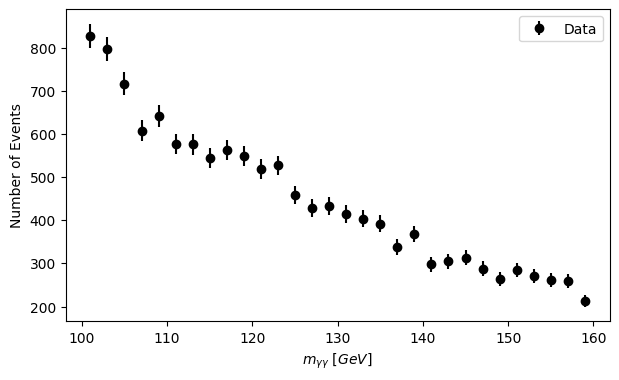

In [ ]:
data_visualizer(Hboson_mass)

Ya estamos casi! Pero primero debemos hacer un ajuste de un módelo a estos datos. Como se explicó en la sesión de introdución de esta Master Class, cuando uno realiza busquedas de particulas uno debe encontrar un peak o un exceso de datos sobre un background. De acuerdo a la estadística, este peak debiese estar localizado en una cierta región que se denomina región de señal y las regiones exteriores a estas se denominan regiones de control, las cuales son regiones en donde no se encuentra nuestra señal o en otras palabras son regiones enriquecidas de background. Para este caso particular el background se modela con una función polinomial y la señal se modela con una ditribución de Gauss, de esta forma el modelo total corresponde a la suma de estas dos contribuciones. La siguiente función implementa este modelo, esta toma como entrada el arreglo con la masa del Higgs y da como salida el ajuste del modelo a los datos:  

In [ ]:
def data_fit(data):
    fraction = 0.8
    lumi = 0.5
    xmin = 100 # GeV
    xmax = 160 # GeV
    step_size = 2 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data,
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # data fit

    '''
    Acá la idea es encontrar un modelo apropiado para ajustar a los datos, para eso
    tienen que ir probando con polinomios de diferente orden, el cual se ajustará a
    la región de background
    '''

    ##########################################################
    ##########################################################
    #Dentro del parentesis debe poner el orden del polinomio a considerar para el ajuste
    polynomial_mod = PolynomialModel(4)
    ##########################################################
    ##########################################################


    gaussian_mod = GaussianModel() # Gaussian

    #############################################################################
    #############################################################################
    #Añada los parametros que correspondas al polinomio que mejor se ajuste
    # set initial guesses for the parameters of the polynomial model
    # c0 + c1x + c2x^2 + c3x^3 + c4x^4 + c5x^5 + c6x^6 + c7*x^7
    pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                                x=bin_centres, c0=data_x.max(), c1=0, c2 =0,c3=0,c4=0) #
    #############################################################################
    #############################################################################

    # set initial guesses for the parameters of the Gaussian model
    pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                               x=bin_centres, amplitude=100,
                               center=125, sigma=2 )

    ################################################################
    ################################################################
    #Encuentre el modelo de señal más background
    model = polynomial_mod  + gaussian_mod# combined model
    ################################################################
    ################################################################

    # fit the model to the data
    out = model.fit(data_x, # data to be fit
                    pars, # guesses for the parameters
                    x=bin_centres, weights=1/data_x_errors )

    ###################################################################################
    ###################################################################################
    #Defina los parametros del polinomio
    # background part of fit
    params_dict = out.params.valuesdict() # get the parameters from the fit to data
    c0 = params_dict['c0'] # c0 of c0 + c1x + c2x^2 + c3x^3 + c4x^4 + c5x^5 + c6x^6 + c7x^7
    c1 = params_dict['c1']
    c2 = params_dict['c2']
    c3 = params_dict['c3']
    c4 = params_dict['c4']

     # c1 of c0 + c1x + c2x^2 + c3x^3 + c4x^4 + c5x^5 + c6x^6 + c7x^7
    ###################################################################################
    ###################################################################################




    ###################################################################################
    ###################################################################################
    #Encuentre el polinomio
    # get the background only part of the fit to data
    background = c0 + c1*bin_centres  + c2*bin_centres**2 + c3*bin_centres**3+c4*bin_centres**4
     ###################################################################################
    ###################################################################################


    # data fit - background fit = signal fit
    signal_x = data_x - background


    # *************
    # Main plot
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
    main_axes = plt.gca() # get current axes

    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' means circles
                       label='Data' )

    # plot the signal + background fit
    main_axes.plot(bin_centres, # x
                   out.best_fit, # y
                   '-r', # single red line
                   label='Sig+Bkg Fit ($m_H=125$ GeV)' )

    # plot the background only fit
    main_axes.plot(bin_centres, # x
                   background, # y
                   '--r', # dashed red line
                   label='Bkg (4th order polynomial)' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() )

    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          labelbottom=False, # don't draw tick labels on bottom axis
                          right=True ) # draw ticks on right axis

    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         horizontalalignment='right')

    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 )

    # set minor ticks on the y-axis of the main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )

    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.2, # x
             0.92, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 )

    # Add text 'for education' on plot
    plt.text(0.2, # x
             0.86, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 )

    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.2, # x
             0.8, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # Add a label for the analysis carried out
    plt.text(0.2, # x
             0.74, # y
             r'$H \rightarrow \gamma\gamma$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(frameon=False, # no box around the legend
                     loc='lower left' ) # legend location


    # *************
    # Data-Bkg plot
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes

    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto',
                                                  symmetric=True) )

    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles

    # draw the fit to data
    sub_axes.plot(bin_centres, # x
                  out.best_fit-background, # y
                  '-r' ) # single red line

    # draw the background only fit
    sub_axes.plot(bin_centres, # x
                  background-background, # y
                  '--b' )  # dashed red line

    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )

    # x-axis label
    sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                        x=1, horizontalalignment='right',
                        fontsize=13 )

    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis

    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )

    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Events-Bkg' )


    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

    return

Veamos cómo luce el ajuste:

/usr/local/lib/python3.11/dist-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


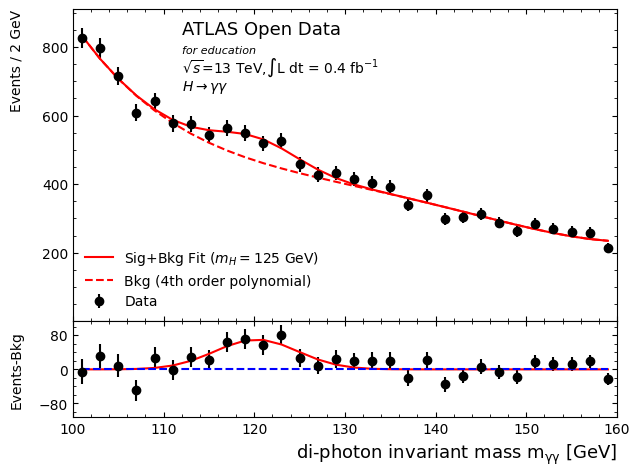

In [ ]:
data_fit(Hboson_mass)

Como vemos el gráfico que hemos obtenido no se parece al mostrado en la introducción, ya que el peak de la región de señal no está cercano a los $125\ [GeV]$. La razón de esto es que no hemos incluido un análisis de cómo los fotones del estado final interactuan con el calorimetro electromágnetico de ATLAS. Para este proposito, debemos aplicar condiciones a nuestros datos de forma tal de filtrarlos y quedarnos sólo con los datos que reflejan este comportamiento. Para esto vamos a definir la siguiente función que toma como entrada todos los arreglos que hemos definido más arriba y nos da cómo salida arreglos filtrados para el momentum transversal $p_T$, la pseudo-rapidez $\eta$, el ángulo azimutal $\phi$ y la energía $E$:

In [ ]:
def filter_data(photon_pt, photon_eta, photon_phi, photon_E, photon_isTightID, photon_etcone20):
    photon_pt_filter = []
    photon_eta_filter = []
    photon_phi_filter = []
    photon_E_filter = []

    for i in range(len(photon_pt[0])):
        #Descomente un condicional a la vez, para ver cómo cambia el gráfico del final ¿Qué conclusiones puede sacar al respecto?


        if photon_pt[0][i] < 40000 or photon_pt[1][i] < 30000:
            continue



        if (abs(photon_eta[0][i]) < 1.52 and abs(photon_eta[0][i]) > 1.37) or (abs(photon_eta[1][i]) < 1.52 and abs(photon_eta[1][i]) > 1.37):
            continue



        if photon_isTightID[0][i] == False or photon_isTightID[1][i] == False:
            continue
        '''

        '''
        if photon_etcone20[0][i] > 4000 or photon_etcone20[1][i] > 4000:
            continue


        photon_pt_filter.append([photon_pt[0][i], photon_pt[1][i]])
        photon_eta_filter.append([photon_eta[0][i], photon_eta[1][i]])
        photon_phi_filter.append([photon_phi[0][i], photon_phi[1][i]])
        photon_E_filter.append([photon_E[0][i], photon_E[1][i]])

    return np.array(photon_pt_filter), np.array(photon_eta_filter), np.array(photon_phi_filter), np.array(photon_E_filter)

De esta forma los arreglos filtrados para las variables $p_T$, $\eta$, $\phi$ y $E$ son de la forma:

In [ ]:
photon_pt_to_calculate_mass_filter  = np.transpose(filter_data(photon_pt_to_calculate_mass, photon_eta_to_calculate_mass, photon_phi_to_calculate_mass, photon_E_to_calculate_mass, photon_isTightID_to_calculate_mass, photon_etcone20_to_calculate_mass)[0])

In [ ]:
photon_eta_to_calculate_mass_filter = np.transpose(filter_data(photon_pt_to_calculate_mass, photon_eta_to_calculate_mass, photon_phi_to_calculate_mass, photon_E_to_calculate_mass, photon_isTightID_to_calculate_mass, photon_etcone20_to_calculate_mass)[1])

In [ ]:
photon_phi_to_calculate_mass_filter = np.transpose(filter_data(photon_pt_to_calculate_mass, photon_eta_to_calculate_mass, photon_phi_to_calculate_mass, photon_E_to_calculate_mass, photon_isTightID_to_calculate_mass, photon_etcone20_to_calculate_mass)[2])

In [ ]:
photon_E_to_calculate_mass_filter   = np.transpose(filter_data(photon_pt_to_calculate_mass, photon_eta_to_calculate_mass, photon_phi_to_calculate_mass, photon_E_to_calculate_mass, photon_isTightID_to_calculate_mass, photon_etcone20_to_calculate_mass)[3])

Por lo tanto, con esto arreglos filtrados podemos calcular nuevamente la masa del bosón de Higgs:

In [ ]:
Hboson_mass_filter = two_photons_invariant_mass(photon_pt_to_calculate_mass_filter, photon_eta_to_calculate_mass_filter, photon_phi_to_calculate_mass_filter, photon_E_to_calculate_mass_filter)

Echemos un vistazo a los datos:

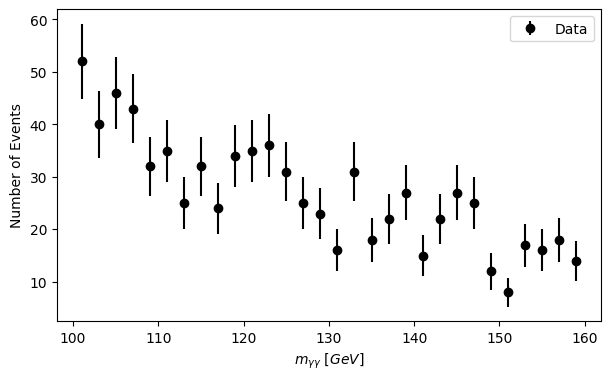

In [ ]:
data_visualizer(Hboson_mass_filter)

Como vemos, la cantidad de datos disminuyo considerablemente. Lo que nos da una señal más limpia en comparación al caso anterior. Finalmente, hagamos un ajuste a estos datos utilizando el mismo modelo:

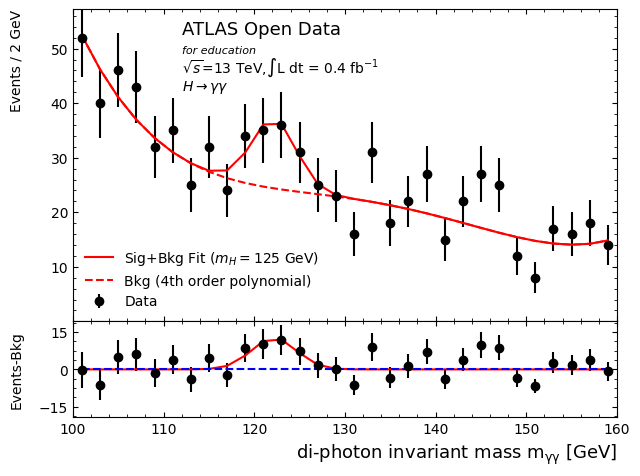

In [ ]:
data_fit(Hboson_mass_filter)

  Finalmente hemos llegado al resultado mostrado en la introducción, en donde podemos ver el peak cercano a los $125\ [GeV]$. Un punto importante a considerar es que este resultado puede mejorar aún más si consideramos más archivos $\textbf{.root}$ en el arreglo $\textrm{data_names}$